In [41]:
import sys
sys.path.append("..")

import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import importlib
import utils
importlib.reload(utils);
from utils import *
from termcolor import colored
from tensorflow.keras import layers, Model, Input

In [4]:
csv_path  = '../data/list_eval_partition.csv'
image_dir = '../data/img_align_celeba/img_align_celeba/'

# Load partition info
df = load_partition_csv(csv_path)

# Build train/val/test file lists
train_files, val_files, test_files = build_file_lists(df, image_dir)

# Create datasets
train_ds = make_image_dataset(train_files, img_size=(64,64), batch_size=64, shuffle=True)
val_ds   = make_image_dataset(val_files,   img_size=(64, 64), batch_size=64)
test_ds  = make_image_dataset(test_files,  img_size=(64, 64), batch_size=64)


## Definicja modelu


In [80]:
BATCH_SIZE = 64
latent_dim = 128  # wymiar przestrzeni latentnej

In [81]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        #batch = tf.shape(z_mean)[0]
        #dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(BATCH_SIZE, latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [114]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder,beta=0.1, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return z_mean,z_log_var,reconstructed
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstructed = self(data)

            kl_loss = -0.5 * tf.reduce_mean(
                z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
            )
            reconstruction_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(data, reconstructed,axis=(1,2,3))
                    #tf.keras.losses.MeanSquaredError()(data,reconstructed)
            )
            total_loss = self.beta * kl_loss + reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss":total_loss,"kl_loss": kl_loss, "reconstruction_loss": reconstruction_loss}
    def test_step(self,data):
        z_mean, z_log_var, reconstructed = self(data)
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(data, reconstructed,axis=(1,2,3))
        )
        total_loss = self.beta * kl_loss + reconstruction_loss
        return {"loss":total_loss,"kl_loss": kl_loss, "reconstruction_loss": reconstruction_loss}

In [98]:
print(colored("Encoder:","red"))
encoder_inputs = Input(shape=(64, 64, 3), name="encoder_input")  
x = layers.Conv2D(32, kernel_size=5, strides=2, padding="same", activation="relu")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, kernel_size=3, strides=1, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
z_mean    = layers.Dense(latent_dim, name="z_mean")(x)      
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean,z_log_var,z], name="encoder")
z_predict = encoder.predict(train_ds.take(1))
print(colored("Test prediction shape of 1 batch:","blue"),z_predict[0].shape)

print(colored("Decoder:","red"))
decoder_input = Input(shape=(latent_dim,), name="z_input")
x = layers.Dense(8 * 8 * 128, activation="relu")(decoder_input)
x = layers.Reshape((8, 8, 128))(x)
x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64,  kernel_size=3, strides=1, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64,  kernel_size=3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32,  kernel_size=5, strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2DTranspose(
        3, kernel_size=3, strides=1, padding="same", activation="sigmoid", name="decoder_output")(x)
decoder = Model(decoder_input, decoder_output, name="conv_decoder")
predict = decoder.predict(z_predict[2])
print(colored("Test prediction shape of 1 batch:","blue"),predict.shape)

Encoder:
1/1 [==============================] - 0s 117ms/step
Test prediction shape of 1 batch: (64, 128)
Decoder:
2/2 [==============================] - 0s 12ms/step
Test prediction shape of 1 batch: (64, 64, 64, 3)


In [107]:
vae = VAE(encoder, decoder,beta=0.1)
initial_learning_rate = 1e-4
decay_steps = 3*2543
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=decay_steps,
                decay_rate=0.98,
                staircase=False)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    start_from_epoch=10,
    patience=5,
    restore_best_weights=True,
    verbose=1
)

vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate))
history = vae.fit(train_ds, epochs=50, validation_data=val_ds,verbose=1)

Epoch 1/50
2543/2543 [==============================] - 169s 65ms/step - loss: 0.0470 - kl_loss: 0.1401 - reconstruction_loss: 0.0330 - val_loss: 0.5722 - val_kl_loss: 0.0920 - val_reconstruction_loss: 0.5631
Epoch 2/50
 772/2543 [========>.....................] - ETA: 1:47 - loss: 0.0396 - kl_loss: 0.0977 - reconstruction_loss: 0.0298

KeyboardInterrupt: 

In [100]:
plotHistory(history=history,validation=True)

NameError: name 'history' is not defined

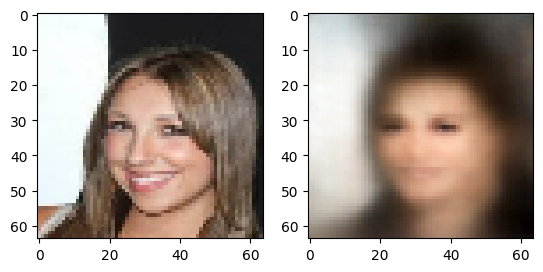

In [113]:
example = next(iter(train_ds))

output = vae(example)[2][0]

fig,axes = plt.subplots(1,2)
pil_img = tf.keras.preprocessing.image.array_to_img(example[0].numpy())
axes[0].imshow(pil_img)
pil_img = tf.keras.preprocessing.image.array_to_img(output.numpy())
axes[1].imshow(pil_img)
plt.show()